In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import os

In [4]:
!pip install -q kaggle
from google.colab import files
print("Please upload the kaggle.json file you downloaded from your kaggle account.")
files.upload()

!mkdir -p /root/.config/kaggle
!mv kaggle.json /root/.config/kaggle/
!chmod 600 /root/.config/kaggle/kaggle.json
print("\nKaggle API configured successfully.")

Please upload the kaggle.json file you downloaded from your kaggle account.


Saving kaggle.json to kaggle.json

Kaggle API configured successfully.


In [5]:
!kaggle competitions download -c house-prices-advanced-regression-techniques
!unzip -o house-prices-advanced-regression-techniques.zip
print("\nDataset downloaded and unzipped.")

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 79.2MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               

Dataset downloaded and unzipped.


In [6]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [7]:
train_df.set_index('Id', inplace=True)
test_df.set_index('Id', inplace=True)

In [8]:
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
train_df.shape

(1460, 80)

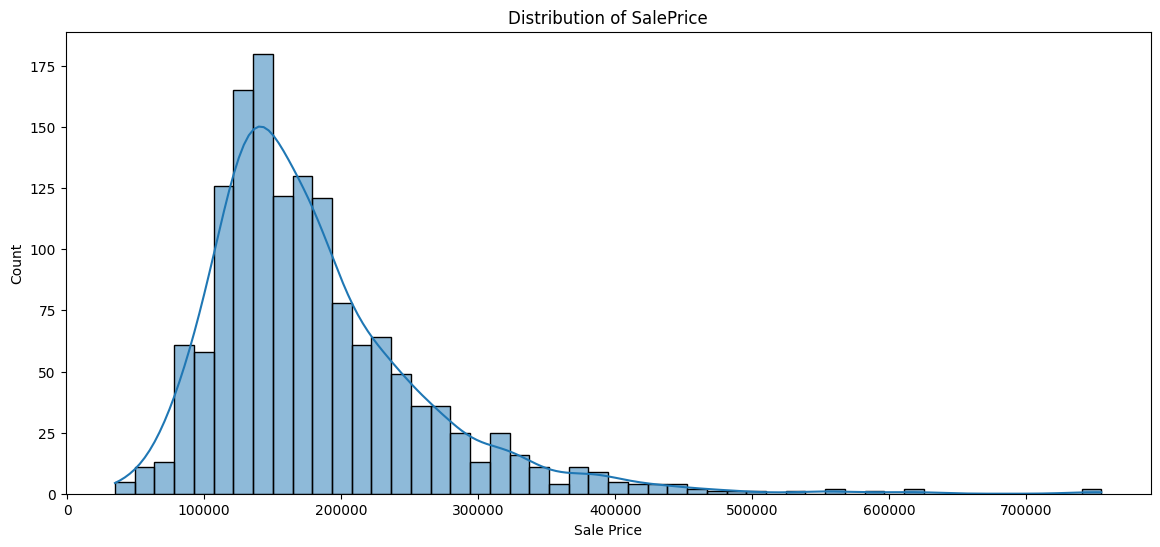

Skewness of SalePrice: 1.8828757597682129


In [10]:
plt.figure(figsize=(14, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50)
plt.title('Distribution of SalePrice')
plt.xlabel('Sale Price')
plt.show()

print(f"Skewness of SalePrice: {train_df['SalePrice'].skew()}")

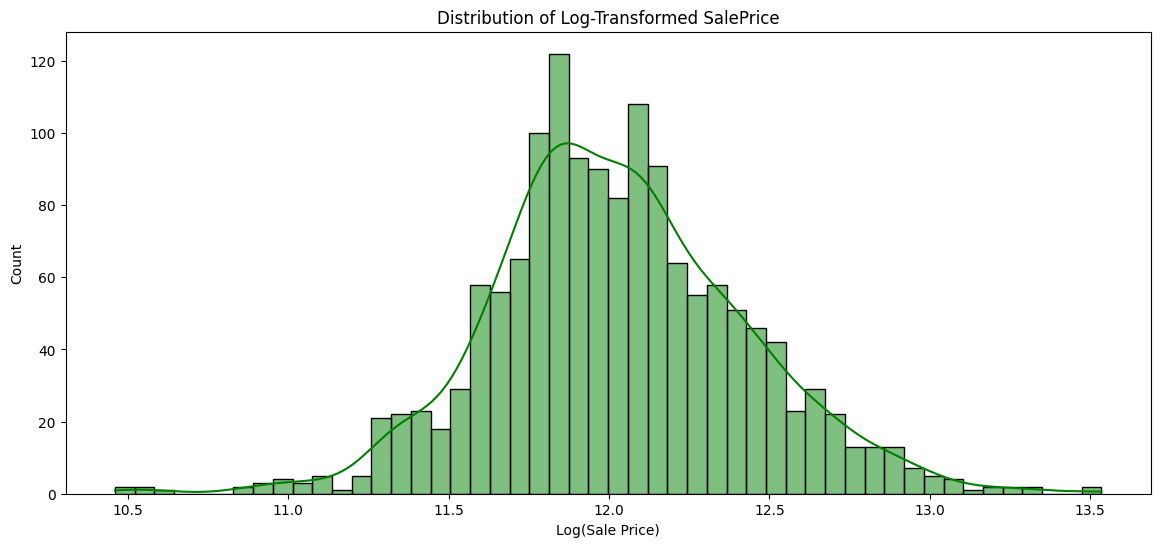

Skewness of Log-Transformed SalePrice: 0.12134661989685333


In [11]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

plt.figure(figsize=(14, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50, color='green')
plt.title('Distribution of Log-Transformed SalePrice')
plt.xlabel('Log(Sale Price)')
plt.show()

print(f"Skewness of Log-Transformed SalePrice: {train_df['SalePrice'].skew()}")

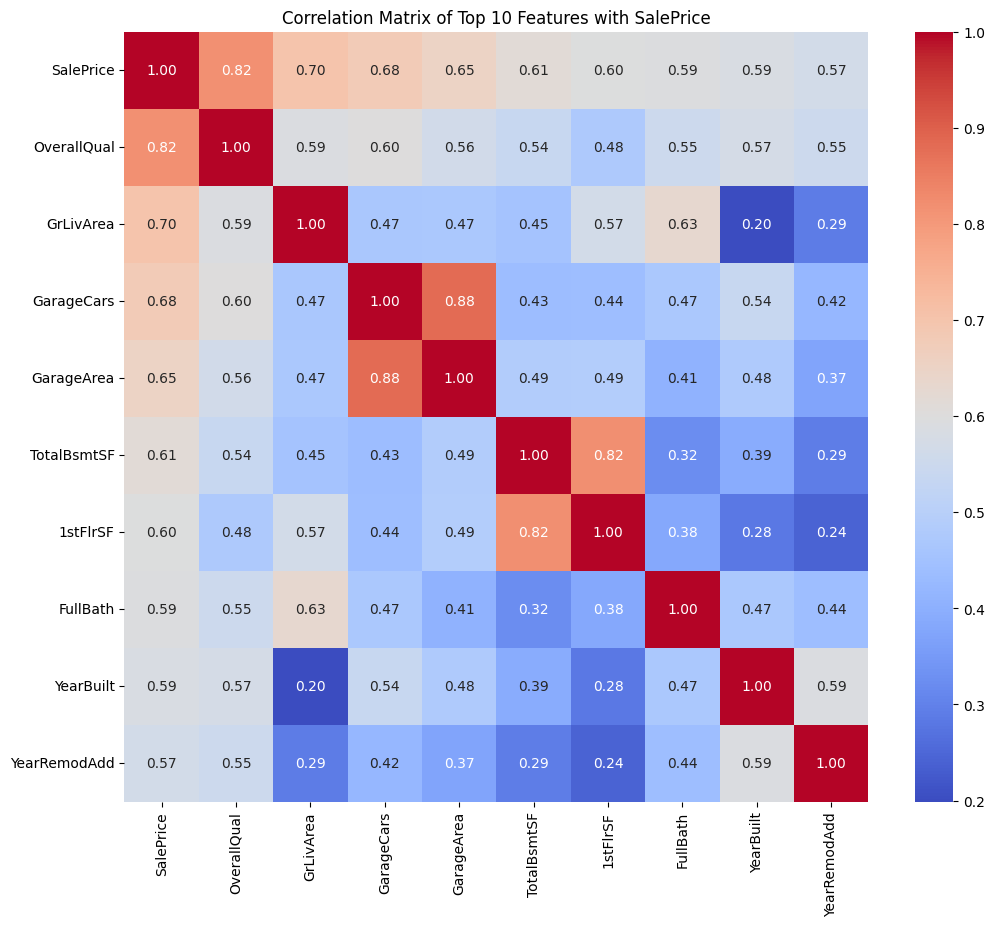

In [12]:
corrmat = train_df.corr(numeric_only=True)
top_corr_features = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
top_corr_matrix = train_df[top_corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Top 10 Features with SalePrice')
plt.show()

In [13]:
cormat = train_df.corr(numeric_only=True)
cormat.nlargest(10, 'SalePrice')['SalePrice'].index

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd'],
      dtype='object')

In [14]:
all_data = pd.concat((train_df.loc[:,:'SaleCondition'],
                      test_df.loc[:,:'SaleCondition']))

print(f"Combined data shape: {all_data.shape}")

Combined data shape: (2919, 79)


In [15]:
missing_data = all_data.isna().sum().sort_values(ascending=False)
missing_data = missing_data[missing_data > 0]

print("Features with missing values:")
print(missing_data)

Features with missing values:
PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
Functional         2
BsmtFullBath       2
Utilities          2
Exterior1st        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF1         1
SaleType           1
KitchenQual        1
GarageCars         1
GarageArea         1
Electrical         1
Exterior2nd        1
BsmtFinSF2         1
dtype: int64


In [16]:
numerical_cols_to_impute_zero = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea', 'BsmtFullBath', 'BsmtHalfBath']
for col in numerical_cols_to_impute_zero:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)

In [17]:
all_data[numerical_cols_to_impute_zero].isnull().sum()

,0
MasVnrArea,0
BsmtFinSF1,0
BsmtFinSF2,0
BsmtUnfSF,0
TotalBsmtSF,0
GarageCars,0
GarageArea,0
BsmtFullBath,0
BsmtHalfBath,0


In [18]:
if 'LotFrontage' in all_data.columns and all_data['LotFrontage'].isna().any():
    all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [19]:
categorical_cols_to_impute_none = ['Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
for col in categorical_cols_to_impute_none:
    if col in all_data.columns: # Check if column exists after one-hot encoding
        all_data[col] = all_data[col].fillna('None')

for col in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities', 'Functional', 'MSZoning']:
    if col in all_data.columns: # Check if column exists after one-hot encoding
        all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [20]:
if 'GarageYrBlt' in all_data.columns:
    all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)


print("\nMissing values after all imputation:", all_data.isna().sum().sum())


Missing values after all imputation: 0


In [21]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                         all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

all_data['Age'] = all_data['YrSold'] - all_data['YearBuilt']

print("New features created.")

New features created.


In [22]:
categorical_cols = all_data.select_dtypes(include=['object']).columns
all_data = pd.get_dummies(all_data, columns=categorical_cols, drop_first=True)

print(f"Data shape after encoding: {all_data.shape}")

Data shape after encoding: (2919, 262)


Model Building and Training

In [23]:
X = all_data[:len(train_df)]
y = train_df['SalePrice']
X_test_final = all_data[len(train_df):]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Feature Scaling

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_final_scaled = scaler.transform(X_test_final)

Linear Regression

In [25]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_val_scaled)

XGBoost

In [26]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror',
                        n_estimators=1000,
                        learning_rate=0.05,
                        max_depth=3,
                        min_child_weight=1,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        random_state=42)
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_val)

Model Evaluation - XGBoost

In [27]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R-squared: {r2:.4f}\n")
evaluate_model(y_val, y_pred_xgb, "XGBoost")

--- XGBoost Performance ---
RMSE: 0.1315
MAE:  0.0858
R-squared: 0.9073



Model Evaluation - Linear Regression

In [28]:
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} Performance ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"R-squared: {r2:.4f}\n")
evaluate_model(y_val, y_pred_lr, "Linear Regression")

--- Linear Regression Performance ---
RMSE: 0.1734
MAE:  0.0960
R-squared: 0.8389



Hyperparameter Tuning

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [30]:
import xgboost as xgb

baseline_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_val)
evaluate_model(y_val, y_pred, "Baseline XGBoost")


--- Baseline XGBoost Performance ---
RMSE: 0.1542
MAE:  0.1034
R-squared: 0.8725



In [37]:
import xgboost as xgb

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.05,
    n_estimators=500,
    max_depth=4,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)
evaluate_model(y_val, y_pred, "XGBoost (No Early Stopping)")


--- XGBoost (No Early Stopping) Performance ---
RMSE: 0.1369
MAE:  0.0906
R-squared: 0.8995



In [45]:
from sklearn.metrics import mean_squared_error
import numpy as np

depths = [3, 4, 5, 6]
child_weights = [1, 3, 5]

best_score = float('inf')
best_params = {}

for d in depths:
    for cw in child_weights:
        model = xgb.XGBRegressor(
            max_depth=d,
            min_child_weight=cw,
            learning_rate=0.05,
            n_estimators=500,
            objective='reg:squarederror',
            random_state=42
        )

        model.fit(X_train, y_train)

        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))

        print(f"depth={d}, child_weight={cw}, RMSE={rmse}")

        if rmse < best_score:
            best_score = rmse
            best_params = {'max_depth': d, 'min_child_weight': cw}


depth=3, child_weight=1, RMSE=0.1358490928279232
depth=3, child_weight=3, RMSE=0.13734454996627407
depth=3, child_weight=5, RMSE=0.13577492237901306
depth=4, child_weight=1, RMSE=0.1369250666027547
depth=4, child_weight=3, RMSE=0.13990690441279297
depth=4, child_weight=5, RMSE=0.13790645723361558
depth=5, child_weight=1, RMSE=0.13516273777300244
depth=5, child_weight=3, RMSE=0.13886145753379875
depth=5, child_weight=5, RMSE=0.14196215497364065
depth=6, child_weight=1, RMSE=0.1387025004113964
depth=6, child_weight=3, RMSE=0.1425003097852009
depth=6, child_weight=5, RMSE=0.14169992928322733


In [47]:
from sklearn.metrics import mean_squared_error
import numpy as np

subsamples = [0.7, 0.8, 0.9, 1.0]
colsamples = [0.7, 0.8, 0.9, 1.0]

best_combo = None
best_score = float('inf')

for ss in subsamples:
    for cs in colsamples:
        model = xgb.XGBRegressor(
            max_depth=best_params['max_depth'],
            min_child_weight=best_params['min_child_weight'],
            subsample=ss,
            colsample_bytree=cs,
            learning_rate=0.05,
            n_estimators=500,
            objective='reg:squarederror',
            random_state=42
        )

        model.fit(X_train, y_train)

        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))

        print(f"subsample={ss}, colsample={cs}, RMSE={rmse}")

        if rmse < best_score:
            best_score = rmse
            best_combo = (ss, cs)


subsample=0.7, colsample=0.7, RMSE=0.13308022441908243
subsample=0.7, colsample=0.8, RMSE=0.133418467940933
subsample=0.7, colsample=0.9, RMSE=0.1357530518234373
subsample=0.7, colsample=1.0, RMSE=0.1365192981364735
subsample=0.8, colsample=0.7, RMSE=0.1334978520228674
subsample=0.8, colsample=0.8, RMSE=0.13407728130225505
subsample=0.8, colsample=0.9, RMSE=0.13559905083184937
subsample=0.8, colsample=1.0, RMSE=0.1362185926780452
subsample=0.9, colsample=0.7, RMSE=0.13639119854570297
subsample=0.9, colsample=0.8, RMSE=0.13606447599688468
subsample=0.9, colsample=0.9, RMSE=0.1374597773638792
subsample=0.9, colsample=1.0, RMSE=0.13728871519086733
subsample=1.0, colsample=0.7, RMSE=0.1363619112604023
subsample=1.0, colsample=0.8, RMSE=0.1353463660711609
subsample=1.0, colsample=0.9, RMSE=0.13511111916799842
subsample=1.0, colsample=1.0, RMSE=0.13516273777300244


In [50]:
import xgboost as xgb

final_model = xgb.XGBRegressor(
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    best_lr = 0.05,
    subsample=best_combo[0],
    colsample_bytree=best_combo[1],
    n_estimators=500,
    objective='reg:squarederror',
    random_state=42
)

final_model.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:51:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "best_lr" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, best_lr=0.05, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, ...)

In [51]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = final_model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("Final Tuned XGBoost Results")
print("RMSE:", rmse)
print("R²:", r2)

Final Tuned XGBoost Results
RMSE: 0.14398558958881846
R²: 0.888903380417233


In [52]:
final_predictions_log = xgbr.predict(X_test_final)

final_predictions = np.expm1(final_predictions_log)

submission = pd.DataFrame({'Id': test_df.index, 'SalePrice': final_predictions})

submission.to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully.")
submission.head()

Submission file 'submission.csv' created successfully.


,Id,SalePrice
0,1461,125996.656250
1,1462,166337.156250
2,1463,187915.328125
3,1464,197955.718750
4,1465,182225.312500
